In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [3]:
data = pd.read_csv('../data/UCBadmit.csv', sep=';').reset_index(drop=True)

dept_idx = (
    data.dept.drop_duplicates().sort_values().reset_index(drop=True).reset_index()
    .set_index('dept')['index'].rename('dept_i').to_frame()
)

data = pd.merge(
    data,
    dept_idx,
    left_on='dept',
    right_index=True)

data = data.assign(
    is_male=(data['applicant.gender'] == 'male').astype('int'),
    ratio=data.admit / data.applications)

data

,dept,applicant.gender,admit,reject,applications,dept_i,is_male,ratio
0,A,male,512,313,825,0,1,0.620606
1,A,female,89,19,108,0,0,0.824074
2,B,male,353,207,560,1,1,0.630357
3,B,female,17,8,25,1,0,0.680000
4,C,male,120,205,325,2,1,0.369231
5,C,female,202,391,593,2,0,0.340641
6,D,male,138,279,417,3,1,0.330935
7,D,female,131,244,375,3,0,0.349333
8,E,male,53,138,191,4,1,0.277487
9,E,female,94,299,393,4,0,0.239186


In [8]:
with pm.Model() as m_betabin:
    alpha = pm.Normal('alpha', mu=0, sd=2)
    beta = pm.Exponential('beta', lam=1)
    
    logit_p = alpha
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))

    admit = pm.BetaBinomial('admit', n=data.applications.values,
                            alpha=p, beta=beta,
                            observed=data.admit.values)

    m_betabin.name = 'beta binomial'
    m_betabin.trace = pm.sample(5000, tune=3000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:13<00:00, 1204.37draws/s]


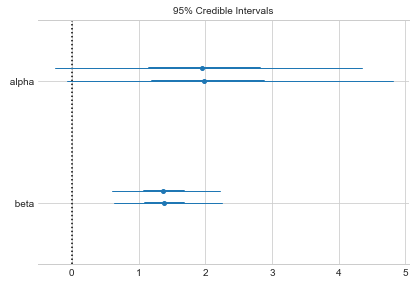

In [9]:
pm.forestplot(m_betabin.trace, varnames=['alpha', 'beta'], rhat=False)
None

In [10]:
with pm.Model() as m_betabin_gender:
    alpha = pm.Normal('alpha', mu=0, sd=2)
    beta = pm.Exponential('beta', lam=1)
    
    beta_male = pm.Normal('beta_male', mu=0, sd=1)
    logit_p = alpha + beta_male * data.is_male.values

    p = pm.Deterministic('p', pm.math.invlogit(logit_p))

    admit = pm.BetaBinomial('admit', n=data.applications.values,
                            alpha=p, beta=beta,
                            observed=data.admit.values)

    m_betabin_gender.name = 'beta binomial & gender'
    m_betabin_gender.trace = pm.sample(5000, tune=3000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_male, beta, alpha]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:15<00:00, 1032.97draws/s]


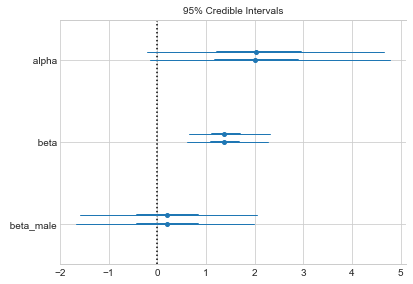

In [12]:
pm.forestplot(m_betabin_gender.trace, varnames=['alpha', 'beta', 'beta_male'], rhat=False)
None

In [14]:
with pm.Model() as m_betabin_complete:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=data.dept_i.nunique())
    beta = pm.Exponential('beta', lam=1)

    beta_male = pm.Normal('beta_male', mu=0, sd=1)
    logit_p = (
        alpha[data.dept_i]
        + beta_male * data.is_male.values
    )

    p = pm.Deterministic('p', pm.math.invlogit(logit_p))

    admit = pm.BetaBinomial('admit', n=data.applications.values,
                            alpha=p, beta=beta,
                            observed=data.admit.values)

    m_betabin_complete.name = 'beta binomial - complete'
    m_betabin_complete.trace = pm.sample(5000, tune=3000, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_male, beta, alpha]
/home/petrushev/etc/jup_env/lib/python3.7/

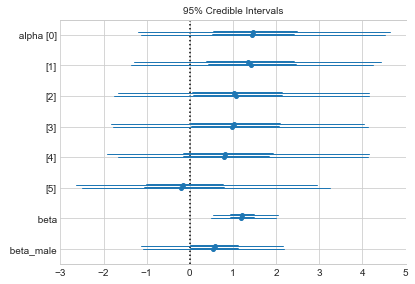

In [15]:
pm.forestplot(m_betabin_complete.trace, varnames=['alpha', 'beta', 'beta_male'], rhat=False)
None